## Using Keras for Word Embedding as well as the LSTM

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://keras.io/getting-started/functional-api-guide/

In [12]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import keras
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
sys.path.append("..")

from app.services.data_preparation import get_processed_data_sets_for_model, DATA_FILES_DIR, TIME_OFFSET
from app.services.sentence_tokenizer import get_chat_log_sequences, MAX_CHAT_LENGTH, TOP_WORDS
from keras.layers import Bidirectional, Dense, Dropout, Input, LSTM, TimeDistributed, LeakyReLU
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from os.path import join

In [2]:
processed_data, data_type_log_ids, train_validation_and_test_dates = get_processed_data_sets_for_model()

In [3]:
processed_data["validation_features_X"].tail()

,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
3572,0.997990,0.158730,0.0,0.208406,0.025535,0.057232
3573,0.998492,0.015873,0.0,0.000000,0.016537,0.685186
3574,0.998995,0.031746,0.0,0.233131,0.015752,0.259289
3575,0.999497,0.015873,0.0,0.656124,0.034522,0.501867
3576,1.000000,0.095238,0.0,0.230761,0.030084,0.077018


In [4]:
train_features_X = processed_data["train_features_X"]
validation_features_X = processed_data["validation_features_X"]
test_features_X = processed_data["test_features_X"]
print(train_features_X.tail())

assert train_features_X.shape[1] == test_features_X.shape[1] 
assert test_features_X.shape[1] == validation_features_X.shape[1] 
print(test_features_X.shape)
test_features_X.head()

       absolute_sentence_position  sentence_length  number_of_special_terms  \
13728                    0.992537         0.082192                 0.027027   
13729                    0.994403         0.000000                 0.000000   
13730                    0.996269         0.438356                 0.027027   
13731                    0.998134         0.027397                 0.027027   
13732                    1.000000         0.041096                 0.000000   

       sentiment_score  normalized_mean_tf_idf  normalized_mean_tf_isf  
13728         0.680659                0.007117                0.100894  
13729         0.481478                0.000000                0.000000  
13730         0.714451                0.006696                0.017713  
13731         0.481478                0.004437                0.322041  
13732         0.000000                0.004600                0.209270  
(3405, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
0,0.001182,0.028169,0.142857,0.000000,0.005692,0.368636
1,0.002364,0.084507,0.285714,0.000000,0.007438,0.114519
2,0.003546,0.028169,0.000000,0.000000,0.006591,0.260825
3,0.004728,0.098592,0.000000,0.000000,0.011325,0.086599
4,0.005910,0.014085,0.000000,0.160904,0.006633,0.665037


In [5]:
train_X, train_chat_logs = get_chat_log_sequences(data_type_log_ids["train"])
validation_X, validation_chat_logs = get_chat_log_sequences(data_type_log_ids["validation"])
test_X, test_chat_logs = get_chat_log_sequences(data_type_log_ids["test"])
print(train_X.shape)
print(test_X.shape)
print(train_X[:1])
print(len(test_X))
test_chat_logs[:2]


(13733, 100)
(3405, 100)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    4 1359   18  108   15    3 4900  918   12  115
   786   14]]
3405


['hey reinhard\n', 'did jonas ever hack on GNUe?\n']

In [6]:
train_y = processed_data["train_y"]
validation_y = processed_data["validation_y"]
test_y = processed_data["test_y"]
print(test_y.shape)
test_y

(3405, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [7]:
data_type_log_ids["test"][:5]

[144080, 144081, 144082, 144083, 144084]

In [28]:
train_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [58]:
train_y_labels = [0 if list(label) == [1, 0] else 1 for label in train_y]
train_y_labels[60: 80]
np.unique(train_y_labels)
# j = [1,0]
# j == [1,0]
# list(train_y[0])

array([0, 1])

In [8]:
# Sentence input: meant to receive sequences of `max_chat_length` integers, between 1 and `top_words`.
main_sentence_input = Input(shape=(MAX_CHAT_LENGTH,), dtype='int32', name='main_sentence_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=TOP_WORDS, input_length=MAX_CHAT_LENGTH)(main_sentence_input)

# An LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [60]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_y_labels),
    train_y_labels
)
class_weights

array([ 0.51756237, 14.73497854])

In [81]:
EPOCHS = 70
BATCH_SIZE = 128
OPTIMIZER = "rmsprop"
OUTPUT_ACTIVATION = "sigmoid"
# Here we insert the auxiliary loss, allowing the LSTM and Embedding layer 
# to be trained smoothly even though the main loss will be much higher in the model.
auxiliary_output = Dense(2, activation=OUTPUT_ACTIVATION, name='aux_output')(lstm_out)

# At this point, we feed into the model our auxiliary input data by 
# concatenating it with the LSTM output
num_of_feature_columns = test_features_X.shape[1]
sentence_features_input = Input(shape=(num_of_feature_columns,), name='sentence_features_input')
merged_input_and_output = keras.layers.concatenate([lstm_out, sentence_features_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(merged_input_and_output)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(2, activation=OUTPUT_ACTIVATION, name='main_output')(x)

In [82]:
# Define a model with two inputs and two outputs
merged_model = Model(
    inputs=[main_sentence_input, sentence_features_input], 
    outputs=[main_output, auxiliary_output]
)

We compile the model and assign a weight of 0.2 to the auxiliary loss. To specify different loss_weights or loss for each different output, you can use a list or a dictionary. Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.

In [83]:
merged_model.compile(
    optimizer=OPTIMIZER, 
    #optimizer="adam",
    loss='categorical_crossentropy',
    #loss_weights=[1., 0.2]
)
merged_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_sentence_input (InputLayer (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 512)     51200000    main_sentence_input[0][0]        
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           69760       embedding_1[0][0]                
__________________________________________________________________________________________________
sentence_features_input (InputL (None, 6)            0                                            
__________________________________________________________________________________________________
concatenat

In [97]:
# Train the model by passing it lists of input arrays and target arrays 19960.996418952942  seconds
# 25183.798012971878  seconds Second time, with 30 minute break in between
start = time.time()
merged_model_history = merged_model.fit(
    [train_X, train_features_X], 
    [train_y, train_y],
    #validation_split=0.2,
    validation_data=[
        [validation_X, validation_features_X], 
        [validation_y, validation_y]
    ],
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    #class_weight=[class_weights, class_weights]
)
end = time.time()
time_taken_in_minutes = (end-start)//60
print(end - start, " seconds")

Train on 13733 samples, validate on 3577 samples
Epoch 1/70
13733/13733 [==============================] - 78s 6ms/step - loss: 0.0178 - main_output_loss: 0.0117 - aux_output_loss: 0.0060 - val_loss: 3.7983 - val_main_output_loss: 2.6700 - val_aux_output_loss: 1.1284
Epoch 2/70
13733/13733 [==============================] - 78s 6ms/step - loss: 0.0075 - main_output_loss: 0.0041 - aux_output_loss: 0.0034 - val_loss: 3.3078 - val_main_output_loss: 2.2878 - val_aux_output_loss: 1.0200
Epoch 3/70
13733/13733 [==============================] - 77s 6ms/step - loss: 0.0065 - main_output_loss: 0.0034 - aux_output_loss: 0.0032 - val_loss: 4.0406 - val_main_output_loss: 2.8955 - val_aux_output_loss: 1.1452
Epoch 4/70
13733/13733 [==============================] - 77s 6ms/step - loss: 0.0059 - main_output_loss: 0.0028 - aux_output_loss: 0.0031 - val_loss: 3.5229 - val_main_output_loss: 2.4982 - val_aux_output_loss: 1.0247
Epoch 5/70
13733/13733 [==============================] - 80s 6ms/step - lo

13733/13733 [==============================] - 78s 6ms/step - loss: 0.0077 - main_output_loss: 0.0044 - aux_output_loss: 0.0033 - val_loss: 3.2461 - val_main_output_loss: 2.0373 - val_aux_output_loss: 1.2088
Epoch 39/70
13733/13733 [==============================] - 80s 6ms/step - loss: 0.0062 - main_output_loss: 0.0030 - aux_output_loss: 0.0032 - val_loss: 3.1328 - val_main_output_loss: 1.9963 - val_aux_output_loss: 1.1365
Epoch 40/70
13733/13733 [==============================] - 79s 6ms/step - loss: 0.0059 - main_output_loss: 0.0029 - aux_output_loss: 0.0030 - val_loss: 3.3764 - val_main_output_loss: 2.1102 - val_aux_output_loss: 1.2662
Epoch 41/70
13733/13733 [==============================] - 79s 6ms/step - loss: 0.0085 - main_output_loss: 0.0045 - aux_output_loss: 0.0040 - val_loss: 2.9905 - val_main_output_loss: 1.9274 - val_aux_output_loss: 1.0631
Epoch 42/70
13733/13733 [==============================] - 79s 6ms/step - loss: 0.0061 - main_output_loss: 0.0031 - aux_output_loss:

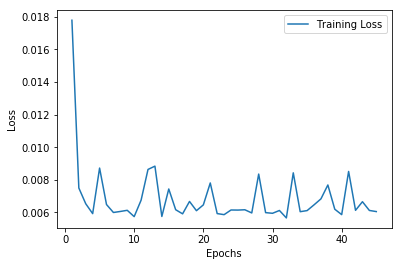

In [99]:
merged_model_loss_values = merged_model_history.history['loss']
merged_model_epochs = range(1, len(merged_model_loss_values)+1)

plt.plot(merged_model_epochs, merged_model_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [100]:
time_now = time.time()
month_day =time.strftime("%m-%d")
time_diff = int(time_now-TIME_OFFSET)
time_diff

524213

In [101]:
# current_time = time.strftime("%Y-%m-%d-(%H_%M_%S)")
merged_model_filename = month_day + "d_{}df_{}e_{}bs_{}_{}min".format(
    time_diff, 
    EPOCHS, 
    BATCH_SIZE, 
    OPTIMIZER,
    int(time_taken_in_minutes)
)
MODELS_DIR = join(DATA_FILES_DIR, "models")
merged_model_filename = join(MODELS_DIR,  merged_model_filename + '_merged_hybrid_model.h5')
merged_model_filename

'../feature_extraction/data_files/models/04-08d_524213df_70e_128bs_rmsprop_92min_merged_hybrid_model.h5'

In [102]:
merged_model.save(merged_model_filename)

In [103]:
loaded_merged_model = load_model(merged_model_filename)

In [104]:
test_y_predictions = loaded_merged_model.predict([test_X, test_features_X])
validation_y_predictions = loaded_merged_model.predict([validation_X, validation_features_X])

test_y_argmax = np.argmax(test_y,axis=1)
validation_y_argmax = np.argmax(validation_y,axis=1)

test_y_predictions_argmax = np.argmax(test_y_predictions[1], axis=1)
validation_y_predictions_argmax = np.argmax(validation_y_predictions[1], axis=1)

In [106]:
test_y_predictions[:10]

[array([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=float32), array([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=float32)]

In [108]:
test_y_predictions_argmax[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [109]:
test_y_argmax[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [110]:
print(classification_report(test_y_argmax, test_y_predictions_argmax))
print(confusion_matrix(test_y_argmax, test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3282
           1       0.00      0.00      0.00       123

   micro avg       0.96      0.96      0.96      3405
   macro avg       0.48      0.50      0.49      3405
weighted avg       0.93      0.96      0.95      3405

[[3282    0]
 [ 123    0]]


In [111]:
from rouge_metrics import *
from get_sentences_from_line_numbers import *

predicted_chat_logs = [test_chat_logs[index] for index, value in enumerate(test_y_predictions_argmax) if value==1]
summaries_chat_logs = [test_chat_logs[index] for index, value in enumerate(test_y_argmax) if value==1]

predicted_chat_logs = "".join(log for log in predicted_chat_logs)
summaries_chat_logs = "".join(log for log in summaries_chat_logs)
print("SUMMARIES\n---------\n", summaries_chat_logs[:1000])
print("PREDICTIONS\n-----------\n", predicted_chat_logs[:1000])

hypotheses = [predicted_chat_logs]
references = [summaries_chat_logs]
print("ROUGE Scores\n------------")
print_rouge_results(get_rouge_results(hypotheses, references))

SUMMARIES
---------
 where you planning a single exception raised to the app level or should I make forms handle the various errors at the app level
it's because the event system can't keep up with the movement
I'm going to make the provider='odbc' and take all the special meaning out of it
what's next big ticket in designer?
need to clean up the UI system
... add drag and drop support for automatically pulling fields/datasources
... generalize the designer code so that it can be used w/reports/etc
... use BOA (if installed) for code editing
insert a duplicate key into table
gnuef used to generate pop up dialogs and recover when a dberror was encountered
say I query 10 records
I have a resultset with 10 recordsets
I change the first 3 
which causes the _updateFlag's to be set on those records
and I insert a new record at the end
I go to commit the changes
and it performs the updates on the first 3
and resets the _updateFlag (since they've been updated)
then inserts the last one
but it 

In [112]:
print(classification_report(validation_y_argmax, validation_y_predictions_argmax))
print(confusion_matrix(validation_y_argmax, validation_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3513
           1       0.00      0.00      0.00        64

   micro avg       0.98      0.98      0.98      3577
   macro avg       0.49      0.50      0.50      3577
weighted avg       0.96      0.98      0.97      3577

[[3513    0]
 [  64    0]]
